In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from math import sqrt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statistics
import seaborn as sns
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [4]:
df = pd.read_csv('noshow_final.csv')

# baseline 구하기 (모두 다 show 라고 말 했을 경우) -> 79.8%  
## (우리의 accuracy goal = 79.8% 이상)

In [5]:
tot_row = df.shape[0]

In [6]:
yes_show = df[df['No-show'] == 0].shape[0]

In [7]:
yes_show / tot_row

0.7981035449955665

# Feature selection

In [8]:
cov_df = df.drop(['AppointmentID','ScheduledDay','AppointmentDay','No-show'],axis=1)

In [9]:
corr_matrix = cov_df.corr()

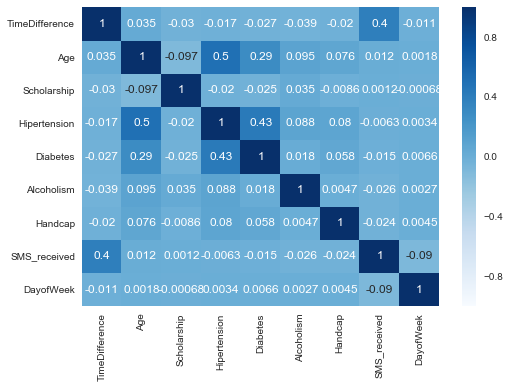

In [10]:
sns.heatmap(corr_matrix, annot = True, cmap="Blues")
plt.show()

## correlation 0.25 초과 인 조합 선별
SMS_received & TimeDifference / Hipertension & Age / Hipertension & Diabetes / Diabetes & Age
둘중 하나는 제거해야함 (변수들간의 dependency 가 존재)

## Random Forest Feature Importance 로 더 중요도가 높은 Feature 선별

In [11]:
df.set_index('AppointmentID', inplace = True)

In [12]:
base_y = df['No-show']

In [13]:
base_x = df.drop(['ScheduledDay','AppointmentDay','No-show'], axis = 1)

In [14]:
base_x.head()

,Gender,TimeDifference,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,DayofWeek
AppointmentID,,,,,,,,,,,
5642903,F,5,60,JARDIM DA PENHA,0,1,0,0,0,0,4
5521232,M,756,30,MARIA ORTIZ,0,0,0,0,0,1,4
5521230,F,756,50,MARIA ORTIZ,0,0,0,0,0,0,4
5523393,F,750,60,MARIA ORTIZ,0,0,0,0,0,1,4
5642808,F,6,60,MARIA ORTIZ,0,0,0,0,0,0,4


In [15]:
gd_dum = pd.get_dummies(base_x['Gender'], prefix = 'Gender')
nb_dum = pd.get_dummies(base_x['Neighbourhood'], prefix = 'Neighbourhood')
dw_dum = pd.get_dummies(base_x['DayofWeek'], prefix = 'DayofWeek')
base_x.drop(['Gender','DayofWeek','Neighbourhood'],axis = 1,inplace = True)
base_x = pd.concat([base_x,gd_dum,dw_dum,nb_dum],axis = 1)

In [16]:
model = RandomForestClassifier(n_estimators = 100, bootstrap = True )

In [17]:
base_x_train,base_x_test,base_y_train,base_y_test=train_test_split(base_x,base_y,test_size=0.2)

In [18]:
base_rf_classifier = model.fit(base_x_train, base_y_train)

In [19]:
important_list =base_rf_classifier.feature_importances_

In [20]:
others = important_list[:8]
Gender_F = important_list[8:10].sum()
Day_F = important_list[10:16].sum()
Neigh_F = important_list[16:].sum()

In [21]:
imp_list = np.append(others, Gender_F)
imp_list = np.append(imp_list, Day_F)
imp_list = np.append(imp_list, Neigh_F)

In [22]:
imp_list

array([0.50104213, 0.11298432, 0.01038488, 0.01112534, 0.01007251,
       0.0070292 , 0.00693389, 0.01998753, 0.02733649, 0.06119172,
       0.231912  ])

In [23]:
all_np = np.sort(imp_list)[::-1]

In [24]:
%matplotlib inline
#%matplotlib tk

In [25]:
plt.figure(figsize=(100,20))

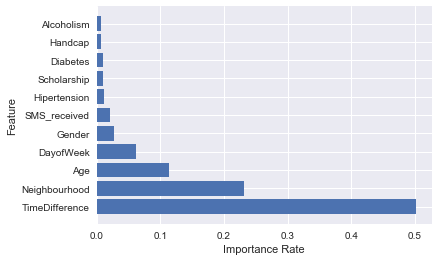

In [26]:
columns = ['TimeDifference', 'Neighbourhood', 'Age', 'DayofWeek','Gender','SMS_received', 'Hipertension', 
           'Scholarship', 'Diabetes', 'Handcap', 'Alcoholism']
ypos = np.arange(11)
plt.barh(ypos,all_np)
plt.tick_params(labelsize=10)
plt.xlabel('Importance Rate')
plt.ylabel('Feature')
plt.yticks(ypos,columns)
plt.show()

## Feature Importance 비교로 인해, 최종적으로 
### SMS_received, Hipertension, Diabetes 제거 

In [27]:
df.drop(['SMS_received','Hipertension','Diabetes'],axis=1, inplace = True)

## Oversampling - SMOTE

In [28]:
len(df[df['No-show'] == 0])

88208

In [29]:
len(df[df['No-show'] == 1])

22314

### No-show 비율이 No-show 하지않은 비율보다 약 4배가 차이나므로 overrsampling 필요

In [30]:
df.drop(['ScheduledDay','AppointmentDay'],axis=1,inplace = True)

In [31]:
y_samp = df['No-show']

In [32]:
x_samp = df.drop(['No-show'],axis=1)

In [33]:
gd_dum = pd.get_dummies(x_samp['Gender'], prefix = 'Gender')
nb_dum = pd.get_dummies(x_samp['Neighbourhood'], prefix = 'Neighbourhood')
dw_dum = pd.get_dummies(x_samp['DayofWeek'], prefix = 'DayofWeek')
x_samp.drop(['Gender','DayofWeek','Neighbourhood'],axis = 1,inplace = True)
x_samp = pd.concat([x_samp,gd_dum,dw_dum,nb_dum],axis = 1)

In [34]:
x_over, y_over = SMOTE(random_state=4).fit_sample(x_samp, y_samp)

In [35]:
len(y_over[y_over==0])

88208

In [36]:
len(y_over[y_over==1])

88208

## Random Forest Classifier 를 통해 예측

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(x_over, y_over, test_size=0.2)

In [38]:
model = RandomForestClassifier(n_estimators = 100, bootstrap = True )

In [39]:
model.fit(X_train, Y_train)

RandomForestClassifier()

In [40]:
predict_ = model.predict(X_test)

In [41]:
accuracy_score(predict_, Y_test)

0.841146128556853

## Baseline (79.8%) 대비 4% 상승 (84%)

# + additional insight!

### 단순 정확도 예측 외에 추천 환자수 제공 알고리즘

In [42]:
df_2016_04_29 = pd.read_csv('noshow_final.csv')

In [43]:
df_2016_04_29['AppointmentDay'] = pd.to_datetime(df_2016_04_29['AppointmentDay']).dt.strftime('%Y-%m-%d')

In [45]:
df_2016_04_29 = df_2016_04_29[df_2016_04_29['AppointmentDay'] =='2016-04-29']

In [46]:
df_tmp = pd.read_csv('noshow_final.csv')

In [47]:
gd_dum_tmp = pd.get_dummies(df_tmp['Gender'], prefix = 'Gender')
nb_dum_tmp = pd.get_dummies(df_tmp['Neighbourhood'], prefix = 'Neighbourhood')
dw_dum_tmp = pd.get_dummies(df_tmp['DayofWeek'], prefix = 'DayofWeek')
df_tmp.drop(['Gender','DayofWeek','Neighbourhood'],axis = 1,inplace = True)
df_tmp_gd = pd.concat([df_tmp,gd_dum_tmp,dw_dum_tmp,nb_dum_tmp],axis = 1)

In [48]:
df_tmp_gd.drop(['AppointmentID','ScheduledDay','AppointmentDay','SMS_received','Hipertension','Diabetes','No-show']
               ,axis=1,inplace = True)

In [49]:
x_test_0429 = df_tmp_gd[df_tmp_gd.index.isin(df_2016_04_29.index)]

In [50]:
threshold = 0.6

In [51]:
possbl_handicap_list = []
possbl_patient_list = []

## 병원에서 자신들의 병원 운영 style 에 맞게 threshold 를 설정하여 
#### (예: 보수적인 병원(vip 병동) = 0.7, 응급실 = 0.3) 
## 신뢰수준에 맞는 추가가능 환자수 및 환자군 특성 파악하여 제시

In [52]:
for i in range(20):
    model.fit(X_train, Y_train)
    prob_group = model.predict_proba(x_test_0429)
    prob_ = pd.DataFrame(prob_group)
    prob_.rename(columns = {0:'come',1:'no_come'},inplace=True)
    res_test = pd.concat([x_test_0429, prob_],axis=1)
    no_show_candidate = res_test[res_test['no_come'] > threshold]
    patient_num ,dummy = no_show_candidate.shape
    handi_num, dummu = no_show_candidate[no_show_candidate['Handcap'] == 1].shape
    possbl_patient_list.append(patient_num)
    possbl_handicap_list.append(handi_num)

In [55]:
upper_hand = statistics.mean(possbl_handicap_list) +(((statistics.stdev(possbl_handicap_list)) / sqrt(20)) * 2.086)
lower_hand = statistics.mean(possbl_handicap_list) -(((statistics.stdev(possbl_handicap_list)) / sqrt(20)) * 2.086)
upper_patient = statistics.mean(possbl_patient_list) +(((statistics.stdev(possbl_patient_list)) / sqrt(20)) * 2.086)
lower_patient = statistics.mean(possbl_patient_list) -(((statistics.stdev(possbl_patient_list)) / sqrt(20)) * 2.086)
d = {'patient': [int(lower_patient), int(upper_patient)], 'handicap': [int(lower_hand), int(upper_hand)]}
poss_tab = pd.DataFrame(data=d)

In [56]:
poss_tab

,handicap,patient
0,5,581
1,5,586


## 신뢰수준 95% 수준 threshold 0.6 기준 환자 총원 581명~586명을 수용할 수 있으며 
## 장애를 가진 환자는 5명까지만 수용 가능하도록 제시
### -> 조금 더 구체적이며 유동적인 접근으로 병원 consulting 가능